In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyspedas
import scienceplots
import xarray as xr
from pyspedas import tinterpol
from pytplot import get_data, options, split_vec, store_data, tplot, tplot_options

# plt.style.use(['science', 'notebook'])

## ARASE Overview

In [2]:
# | code-summary: Retrieve data from the ARASE satellite
# | output: false
trange = ["2021-04-17 00:00:00", "2021-04-17 12:00:00"]
pyspedas.erg.pwe_ofa(trange=trange, time_clip=True, ror=False)
pyspedas.erg.mgf(trange=trange, time_clip=True, ror=False)
pyspedas.erg.orb(trange=trange, time_clip=True, ror=False)
pyspedas.erg.orb(
    trange=trange, level="l3", model="t89", time_clip=True, ror=False
)  # Get equatorial magnetic field data

29-Oct-23 20:14:06: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/pwe/ofa/l2/spec/2021/04/
29-Oct-23 20:14:07: File is current: /Users/zijin/data/ergsc/satellite/erg/pwe/ofa/l2/spec/2021/04/erg_pwe_ofa_l2_spec_20210417_v02_03.cdf
29-Oct-23 20:14:08: /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/pytplot/importers/cdf_to_tplot.py:324: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ydata[ydata == var_atts["FILLVAL"]].size != 0:

29-Oct-23 20:14:08: Time clip was applied to: erg_pwe_ofa_l2_spec_E_spectra_132
29-Oct-23 20:14:08: Time clip was applied to: erg_pwe_ofa_l2_spec_quality_flag_e132
29-Oct-23 20:14:08: Time clip was applied to: erg_pwe_ofa_l2_spec_B_spectra_132
29-Oct-23 20:14:08: Time clip was applied to: erg_pwe_ofa_l2_spec_quality_flag_b132
29-Oct-23 20:14:08: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/sate

['erg_orb_l3_pos_eq_t89',
 'erg_orb_l3_pos_iono_north_t89',
 'erg_orb_l3_pos_iono_south_t89',
 'erg_orb_l3_pos_lmc_t89',
 'erg_orb_l3_pos_lstar_t89',
 'erg_orb_l3_pos_I_t89',
 'erg_orb_l3_pos_blocal_t89',
 'erg_orb_l3_pos_beq_t89']

In [19]:
orb_Lm = get_data("erg_orb_l2_pos_Lm", xarray=True)
store_data("erg_orb_Lm", data={"x": orb_Lm.time, "y": orb_Lm.data[:, 0]})
split_vec(
    "erg_orb_l2_pos_rmlatmlt", new_name="erg_orb_l2_pos_", suffix=["r", "mlat", "mlt"]
)

options("erg_orb_Lm", "ytitle", "Lm")
options("erg_orb_l2_pos_mlt", "ytitle", "MLT")
options("erg_orb_l2_pos_mlat", "ytitle", "MLAT")

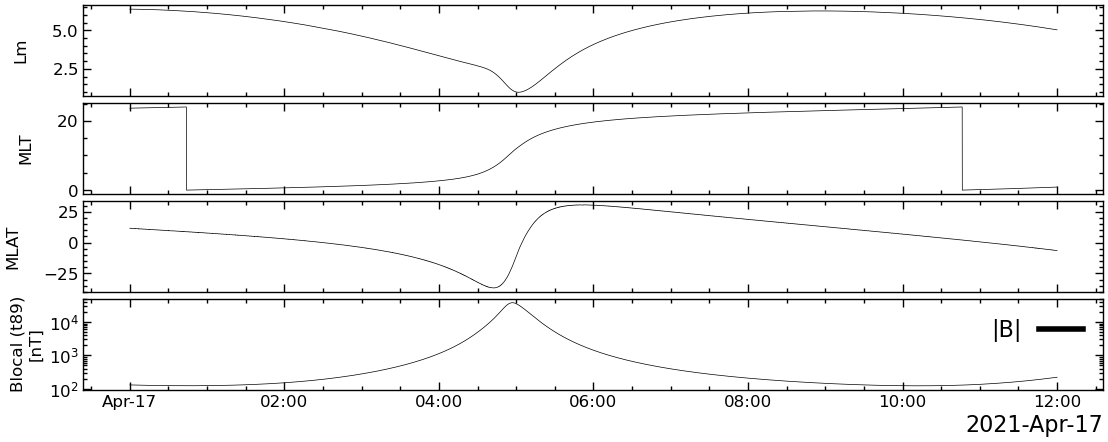

In [20]:
tplot(
    [
        "erg_orb_Lm",
        "erg_orb_l2_pos_mlt",
        "erg_orb_l2_pos_mlat",
        "erg_orb_l3_pos_blocal_t89",
    ]
)

## ARASE observation of whistler wave

Process data from the ERG satellite: retrieve data, interpolate to the same time as the spectra, and export tplot variables

In [21]:
from astropy import units as u
from plasmapy.formulary import gyrofrequency

29-Oct-23 20:17:53: tinterpol (linear) was applied to: erg_mgf_l2_magt_8sec-itrp
29-Oct-23 20:17:53: combined_data does not contain coordinates for spectrogram plotting.  Continuing...
29-Oct-23 20:17:54: /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/pytplot/MPLPlotter/tplot.py:651: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_ticks.append('{:.2f}'.format(var_xr.interp(coords={'time': time}, kwargs={'fill_value': 'extrapolate', 'bounds_error': False}).values))

29-Oct-23 20:17:54: /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/pytpl

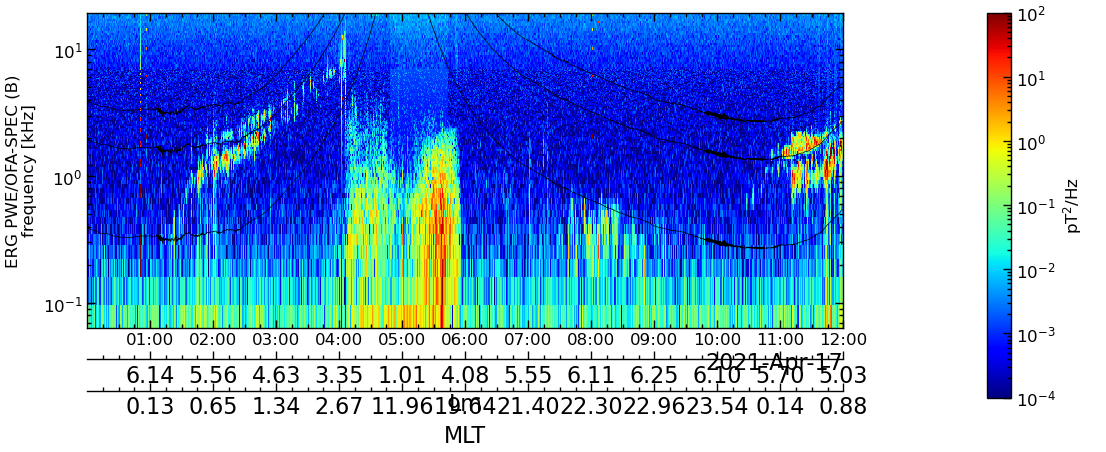

In [22]:
# | code-summary: Overview of ARASE observations
# Plot the PWE data with the gyrofrequency data and magnetic field data

# Store gyrofrequency data with the PWE data
tinterpol("erg_mgf_l2_magt_8sec", "erg_pwe_ofa_l2_spec_B_spectra_132")
erg_mgf_magt = get_data("erg_mgf_l2_magt_8sec-itrp", xarray=True)
mag_t = erg_mgf_magt.data * u.nT

omega_ce = gyrofrequency(mag_t, "e-", to_hz=True).to("kHz")
upper_bound = 0.1 * omega_ce
lower_bound = 0.5 * omega_ce

store_data("omega_e", data={"x": erg_mgf_magt.time, "y": omega_ce})
store_data("omega_e01", data={"x": erg_mgf_magt.time, "y": lower_bound})
store_data("omega_e05", data={"x": erg_mgf_magt.time, "y": upper_bound})

# store the combined data
store_data(
    "combined_data",
    data=["omega_e", "omega_e01", "omega_e05", "erg_pwe_ofa_l2_spec_B_spectra_132"],
)

options("combined_data", "spec", True)

pwe_spec = get_data("erg_pwe_ofa_l2_spec_B_spectra_132")
options("omega_e", "yrange", [pwe_spec.v[0], pwe_spec.v[-1]])


tplot("combined_data", var_label=["erg_orb_Lm", "erg_orb_l2_pos_mlt"])

# NOTE: vector format is very slow to save
# tplot(["combined_data"],save_png='../figures/erg_pwe_spec')

In [23]:
# Interpolate the spacecraft position and magnetic field data to the same time as the spectra
tinterpol("erg_orb_l2_pos_Lm", "erg_pwe_ofa_l2_spec_B_spectra_132")
tinterpol("erg_orb_l3_pos_beq_t89", "erg_pwe_ofa_l2_spec_B_spectra_132")

# Get the data from pytplot variables
pwe_spec_xr = get_data("erg_pwe_ofa_l2_spec_B_spectra_132", xarray=True)
orb_Lm_itrp = get_data("erg_orb_l2_pos_Lm-itrp", xarray=True)

29-Oct-23 20:17:56: tinterpol (linear) was applied to: erg_orb_l2_pos_Lm-itrp


29-Oct-23 20:17:56: tinterpol (linear) was applied to: erg_orb_l3_pos_beq_t89-itrp


Get the whistler waves normalized mean frequencies from Arase mission for calculating diffusion coefficients.

In [24]:
# filter the data

# convert omega_e to a DataArray
omega_e_da = xr.DataArray(omega_ce, coords=[pwe_spec_xr.time], dims=["time"])

lower_bound = 0.1
upper_bound = 0.5
step = 0.025

interested_freq = lambda x: (x.spec_bins < upper_bound * omega_e_da) & (
    x.spec_bins > lower_bound * omega_e_da
)
pwe_spec_filtered = pwe_spec_xr.where(interested_freq, 1e-5)

# only keep the time when the maximum intensity is at the interested frequency (whistler mode)
interested_time = pwe_spec_xr.argmax(dim="v_dim") == pwe_spec_filtered.argmax(
    dim="v_dim"
)
pwe_spec_temp = pwe_spec_xr.where(interested_time)

pwe_spec_filtered = pwe_spec_xr.where(interested_freq).where(interested_time)


def summed_intensity(_lower_bound, _upper_bound):
    interested_freq = lambda x: (x.spec_bins < _upper_bound * omega_e_da) & (
        x.spec_bins > _lower_bound * omega_e_da
    )
    # TODO: better way to acculmulate this intensity for uneven frequency bins
    pwe_spec_freq = (
        pwe_spec_temp.where(interested_freq).mean(dim=["v_dim"])
        * (_upper_bound - _lower_bound)
        * omega_e_da
        * 1000  # convert to Hz
    )

    rel_freq = xr.DataArray(
        [(_upper_bound + _lower_bound) / 2],
        dims=["relative_frequency"],
        attrs={"long_name": "Relative Frequency", "units": r"$\omega_{ce}$"},
    )
    pwe_spec_freq.attrs["long_name"] = "Wave intensity"
    pwe_spec_freq.attrs["units"] = r"$pT^2$"

    return pwe_spec_freq.expand_dims(
        dim={"relative_frequency": rel_freq}
    ).assign_coords({"relative_frequency": rel_freq})


lower_bounds = np.arange(lower_bound, upper_bound, step)
upper_bounds = np.arange(lower_bound + step, upper_bound + step, step)
da = xr.concat(
    [
        summed_intensity(_lower_bound, _upper_bound)
        for _lower_bound, _upper_bound in zip(lower_bounds, upper_bounds)
    ],
    dim="relative_frequency",
)

avg_da = (
    da.assign_coords({"Lm": ("time", orb_Lm_itrp.data[:, 0])})
    .where(lambda x: (x.Lm < 6.5) & (x.Lm > 4.5))
    .mean(dim="time")
)
relative_frequency = avg_da.idxmax().values
print(f"Normalized mean frequencies of whistler waves: {relative_frequency}")

# Plot the summed intensity of the PWE data between 0.1 and 0.5 omega_e
# fig, axs = pplt.subplots()
# axs.plot(avg_da)

Normalized mean frequencies of whistler waves: 0.31249999999999994


29-Oct-23 20:18:11: combined_data does not contain coordinates for spectrogram plotting.  Continuing...


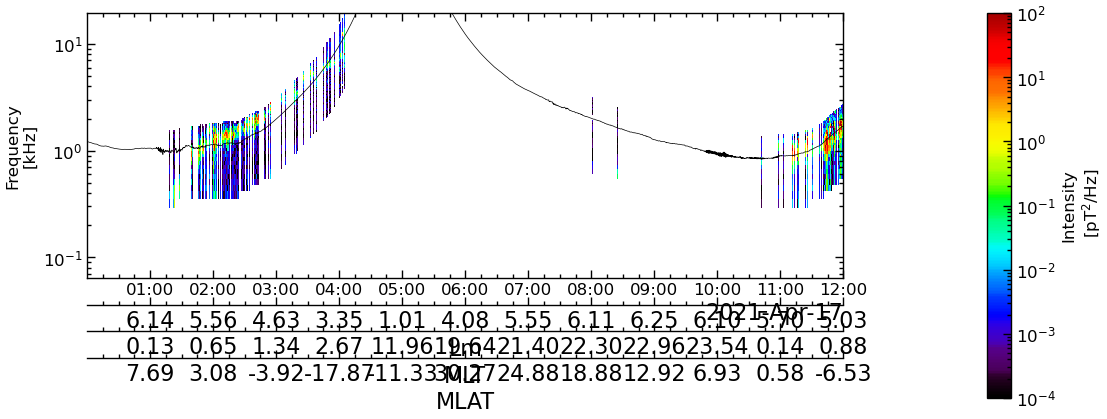

In [25]:
# | code-summary: Whistler mode waves observed by ARASE
# Calculate omega_e_max
omega_e_max = relative_frequency * gyrofrequency(mag_t, "e-", to_hz=True).to("kHz")

# store the filtered data
store_data(
    "pwe_spec_filtered",
    data={
        "x": pwe_spec.times,
        "y": pwe_spec_filtered.where(lambda x: x < 300),
        "v": pwe_spec.v,
    },
)

# Store omega_e_max data
store_data("omega_e_max", data={"x": erg_mgf_magt.time, "y": omega_e_max})

# Store the combined data
combined_data = ["omega_e_max", "pwe_spec_filtered"]
store_data("combined_data", data=combined_data)

# Set options
options("combined_data", "spec", True)
options("pwe_spec_filtered", "spec", True)
options("pwe_spec_filtered", "ylog", True)
options("pwe_spec_filtered", "yrange", [pwe_spec.v[0], pwe_spec.v[-1]])
options("pwe_spec_filtered", "ytitle", "Frequency")
options("pwe_spec_filtered", "ysubtitle", "[kHz]")
options("pwe_spec_filtered", "zlog", True)
options("pwe_spec_filtered", "zrange", [1e-4, 1e2])
options("pwe_spec_filtered", "ztitle", "Intensity")
options("pwe_spec_filtered", "zsubtitle", "[pT^2/Hz]")

# Plot the combined_data
# tplot("combined_data")
tplot(
    "combined_data",
    var_label=["erg_orb_Lm", "erg_orb_l2_pos_mlt", "erg_orb_l2_pos_mlat"],
)

$B_w^2$ (chorus) and F m/F ce of chorus as a function of MLT at L = 5−6 to estimate the Bw2 (chorus) at 23-12 MLT, and next calculate Dαα(chorus) for each energy, and multiply it by ∼ 1/2 to get the MLT-averaged Dαα(chorus) using F pe/F ce from Sheeley outside the plasmasphere. If Bw2 (chorus) is mostly from 23-06 MLT, then the MLT-averaged Dαα(chorus) would be ∼ 1/3 of the calculated Dαα.

In [10]:
# Interpolate the spacecraft position to the same time as the spectra
tinterpol("erg_orb_l2_pos_mlt", "erg_pwe_ofa_l2_spec_B_spectra_132")
tinterpol("erg_orb_l2_pos_Lm", "erg_pwe_ofa_l2_spec_B_spectra_132")

orb_Lm_itrp = get_data("erg_orb_l2_pos_Lm-itrp", xarray=True)
orb_mlt_itrp = get_data("erg_orb_l2_pos_mlt-itrp", xarray=True)

29-Oct-23 20:14:16: tinterpol (linear) was applied to: erg_orb_l2_pos_mlt-itrp
29-Oct-23 20:14:16: tinterpol (linear) was applied to: erg_orb_l2_pos_Lm-itrp


In [11]:
weighted_freq = (
    xr.concat(
        [
            xr.DataArray([0], coords={"spec_bins": ("v_dim", [0])}, dims=["v_dim"]),
            pwe_spec_filtered.spec_bins.drop("v"),
        ],
        dim="v_dim",
    ).diff(dim="v_dim")
    * 1000
)  # convert to Hz

29-Oct-23 20:14:16: /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/xarray/core/dataarray.py:3114: PendingDeprecationWarning: dropping variables using `drop` will be deprecated; using drop_vars is encouraged.
  ds = self._to_temp_dataset().drop(labels, dim, errors=errors, **labels_kwargs)



Calculate averaged $B_w^2$ (chorus)

In [12]:
Bw_square = (
    pwe_spec_filtered.assign_coords({"Lm": ("time", orb_Lm_itrp.data[:, 0])})
    .where(lambda x: (x.Lm < 6.5) & (x.Lm > 4.5))  # filter Lm
    .where(lambda x: x < 300)
    .weighted(weighted_freq)
    .sum(dim="v_dim")
    .where(
        lambda x: x > 0,  # remove empty data
    )
    .mean(dim="time")
)

print(f"Mean wave intensity: {Bw_square.values}")

Mean wave intensity: 3233.545518646034


In [13]:
# pwe_spec_xr.where(interested_freq).plot(x='time', y='spec_bins', yscale='log')
# pwe_spec_filtered.plot(x='time', y='spec_bins', yscale='log')